<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [44]:
# Some important imports
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import pickle
from mpl_toolkits.mplot3d import Axes3D
sns.set_context('notebook')

# Sklearn imports
import sklearn
from sklearn import calibration
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# Some imports that may require package installation
try:
    import missingno as msno
except ModuleNotFoundError:
    print('You need to run: pip install missingno')

# Own Scripts import
from scripts.energy_test_DP import *
from scripts.utils import *
from scripts.preprocessing import *
from scripts.plot import *
from scripts.model_selection import *

# get rid of warning due to deprecated modules in sklearn
import warnings
warnings.simplefilter('ignore')

# Constants
DATA_FOLDER = './Data'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
x,y,dates = usable_data('27_06',DATA_FOLDER)

Retrieving from ./Data/sample_27_06_sick_only.pk
The sample is composed of : 24173 vectors of dimension 291
	n_sick		=   7110
	n_healthy	=  17063
Deleting 54 features (18.305%).


In [53]:
standard_preproc = make_pipeline(
    sklearn.preprocessing.Imputer(strategy='mean'),
    sklearn.preprocessing.StandardScaler())
simple_preproc = make_pipeline(
    sklearn.preprocessing.Imputer(strategy='mean'))

classifiers = {'Logistic Regression':make_pipeline(
                                        standard_preproc,
                                        sklearn.linear_model.LogisticRegression(C=0.011288, max_iter=500,n_jobs=-1)),
               'GB (scaled)': make_pipeline(standard_preproc,
                                sklearn.ensemble.GradientBoostingClassifier(
                                **{'learning_rate': 0.1125, 
                                 'n_estimators': 64, 
                                 'max_depth': 5, 
                                 'min_samples_split':1000})),
               'GB': make_pipeline(simple_preproc,
                                sklearn.ensemble.GradientBoostingClassifier(
                                **{'learning_rate': 0.050000000000000003, 
                                 'n_estimators': 100, 
                                 'max_depth': 7, 
                                 'min_samples_split':1000}))
              }




In [54]:
def PR_multiple_models(classifiers, x, y, dates,prec_thresh_list=[0.7,0.8,0.9],cv=5, balanced = True, shuffle = True):

    fig,ax = plt.subplots(1,1)
    splits = scripts.model_selection.distinct_date_split(x,y,dates,cv,balanced,shuffle)
    recall_levels = {x:np.zeros((cv,len(prec_thresh_list))) for x in classifiers}
    
    y_real = []
    #create a dict to store each classifiers' results
    all_scores = {x:[] for x in classifiers}
    
    for i,(train_index,test_index) in enumerate(splits):
        x_train, x_test,y_train, y_test = x[train_index], x[test_index], y[train_index], y[test_index]
        
        for clf_name in classifiers.keys():
            clf = classifiers[clf_name]
            clf.fit(x_train,y_train)
            y_proba_sick = clf.predict_proba(x_test)[:,1]
            
            all_scores[clf_name].append(y_proba_sick)
            recalls_for_i,thresholds_for_i = scripts.model_selection.recalls_for_prec_list(y_test,y_proba_sick,prec_thresh_list)
            recall_levels[clf_name][i,:] = recalls_for_i
        
        #store real labels
        y_real.append(y_test)
        
    # create the return string
    to_return = {}
    
    y_real = np.concatenate(y_real)
    for clf_name in classifiers.keys():
        # draw the overall curve
        y_scores = np.concatenate(all_scores[clf_name])
        precision, recall, _ = sklearn.metrics.precision_recall_curve(y_real, y_scores)

        overall_auc = sklearn.metrics.auc(recall,precision)
        lab = clf_name + ' ({:.4f})'.format(overall_auc)
        ax.step(recall, precision, label=lab,where='post',alpha=0.8)
        
        recalls = 100*np.mean(recall_levels[clf_name],axis=0)
        to_return[clf_name] = {'R_{:.2f}'.format(prec_thresh_list[i]):recalls[i] for i in range(0,len(prec_thresh_list))}

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.set_ylim([0.0, 1.05])
    ax.set_xlim([0.0, 1.0])
    ax.legend(loc='upper right', fontsize='small')


    fig.show()

    return to_return 

{'GB': {'R_0.70': 33.323899444630499,
  'R_0.80': 26.239356997603409,
  'R_0.90': 12.89782408405347},
 'GB (scaled)': {'R_0.70': 32.985133763671371,
  'R_0.80': 25.691948991784308,
  'R_0.90': 13.411689798758319},
 'Logistic Regression': {'R_0.70': 24.802814196818918,
  'R_0.80': 15.6742145556625,
  'R_0.90': 4.7516172648697852}}

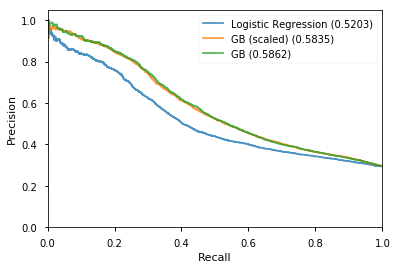

In [55]:
PR_multiple_models(classifiers, x, y,dates)